# 0. TODO
* Create a neural network to approximate the bioprocess
* Input variables: compound A and substrate
* Output variables: biomass

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

# 1. Setup

In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from keras.models import Sequential 
from keras.layers import Dense #Fully connected layer in a NN - each neuron is connected to every neuron in previous and next layer, we can specify number of neurons in layer, activation function and other parameters
from keras.optimizers import Adam 
from keras.optimizers import SGD 

2023-08-02 15:34:16.633248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



The Sequential class will be used to create the model, and Dense layers will be added to define the architecture of the neural network. The Adam and SGD optimizers will be used to update the model's parameters during training. 

In [3]:
# Define Constants
TRAINING_SPLIT = 0.8 #0.8/0.2 split based on recommended practice
BIOMASS_FILE = "biomass.txt" 
COMPOUND_FILE = "compoundA.txt"
SUBSTRATE_FILE = "substrate.txt"

In [4]:
# Takes file location / name and returns a numpy array containing the rows (floats)
def file_to_nparray(filename):

    with open(filename, "r") as f:
        lines = f.readlines()
        data = []

        for line in lines:
            value = float(line.strip())
            data.append(value)
        print(data)
    
    return np.array(data)

In [5]:
biomass = file_to_nparray("biomass.txt")
compoundA = file_to_nparray("compoundA.txt")
substrate = file_to_nparray("substrate.txt")

[0.1, 0.1205, 0.14517081, 0.17484657, 0.21052166, 0.25337841, 0.30481824, 0.36649569, 0.44035472, 0.5286654, 0.6340583, 0.75955181, 0.90856537, 1.08490778, 1.29272526, 1.5363875, 1.82028295, 2.14848647, 2.52425688, 2.94932306, 3.42293475, 3.9407051, 4.4933792, 5.06584773, 5.63697696, 6.18103021, 6.6713126, 7.08577117, 7.41264364, 7.65310832, 7.81911558, 7.92785635, 7.99632545, 8.03826893, 8.06350501, 8.07851825, 8.08738839, 8.09260741, 8.09567063, 8.09746592, 8.09851722, 8.09913253, 8.09949256, 8.09970319, 8.09982639, 8.09989846, 8.09994061, 8.09996526, 8.09997968, 8.09998812, 8.56197535, 8.30514644, 8.42371015, 7.65573404, 7.79220117, 8.03995899, 7.65403938, 7.8148284, 7.92328684, 8.51564245, 8.24798719, 8.16046722, 7.44964191, 7.6890139, 8.70730301, 8.01684033, 8.57478514, 8.43390941, 8.18726365, 7.90934049, 8.1847545, 7.99585367, 8.50146759, 8.43551158, 8.02588536, 7.61361497, 7.60798842, 8.45278563, 7.70524526, 7.92234922, 8.44331909, 8.3090102, 8.39412476, 6.95887908, 7.68179907, 

# 2. Data Preprocessing
* Identify variation range for input and output variables *Note: variation range = difference between max and min variables*
* Plot each variable to observe the overall behaviour of the bio-process
* In case outliers are detected correct the data accordingly. For instance, as we are dealing with variables measured in grams, no value should be less than zero. A simple correction is to replace such values with a zero value.
* Split the data into two subsets: training and test. *Note: we use an 80/20 split of training/test Data*

In [6]:
# Checking variation ranges
all_data = np.column_stack((biomass,compoundA,substrate))
pd.DataFrame(all_data, columns=["biomass","compoundA","substrate"]).describe()
#No large outliers or anomalies that requires large pre-processing effort outside of replacing negative values with zeroes

,biomass,compoundA,substrate
count,1600.000000,1600.000000,1600.000000
mean,4.320069,3.437500,4.735887
std,3.605372,4.751074,4.500161
min,-0.387570,0.000000,-0.689589
25%,0.287887,0.000000,0.068709
50%,4.933330,0.000000,3.985052
75%,8.040682,10.000000,9.807322
max,8.764514,10.000000,10.476012


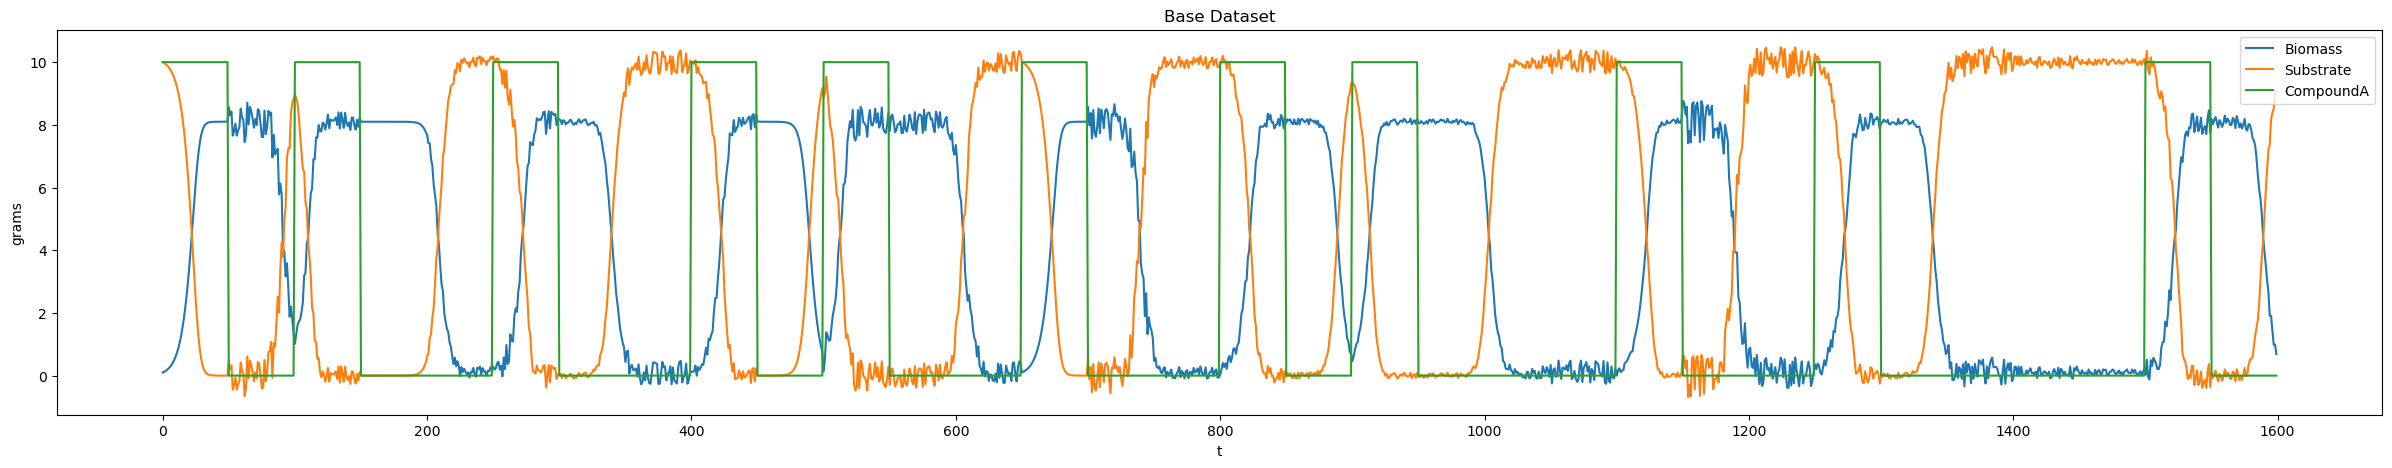

In [7]:
# Chart Data
x = np.arange(0,len(biomass))
plt.figure(figsize=(30,5))

plt.plot(x, biomass, label='Biomass')
plt.plot(x, substrate, label='Substrate')
plt.plot(x, compoundA, label='CompoundA')

plt.xlabel('t')
plt.ylabel('grams')

plt.title('Base Dataset')
plt.legend()
plt.show()

In [8]:
# Clean up data
def remove_negatives(array):
    clean_array = np.copy(array)
    for i in range(0, len(array)):
        if array[i] < 0:
            clean_array[i] = 0 #replace negatives with 0
            # Another strategy is to offset the difference onto Biomass since the mass of the system should remain constant , e.g. system_mass = substrate + biomass
    return clean_array

#Normalise data
def min_max_normalization(array):
    data = np.copy(array)
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def clean_array(array):    
    array = remove_negatives(array)
    #optional pre-processing
    #array = min_max_normalization(array) #normalisation optional since same units used for all data
    #Regularization - prevents overfitting and improves generalization of ML model - adds a penalty to the loss function. L1 - reduces weights of non-important features, L2 - adds penalty when too many weights
    #Scaling
    #Outliers
    return array

biomass_clean = clean_array(biomass)
compoundA_clean = clean_array(compoundA)
substrate_clean = clean_array(substrate)

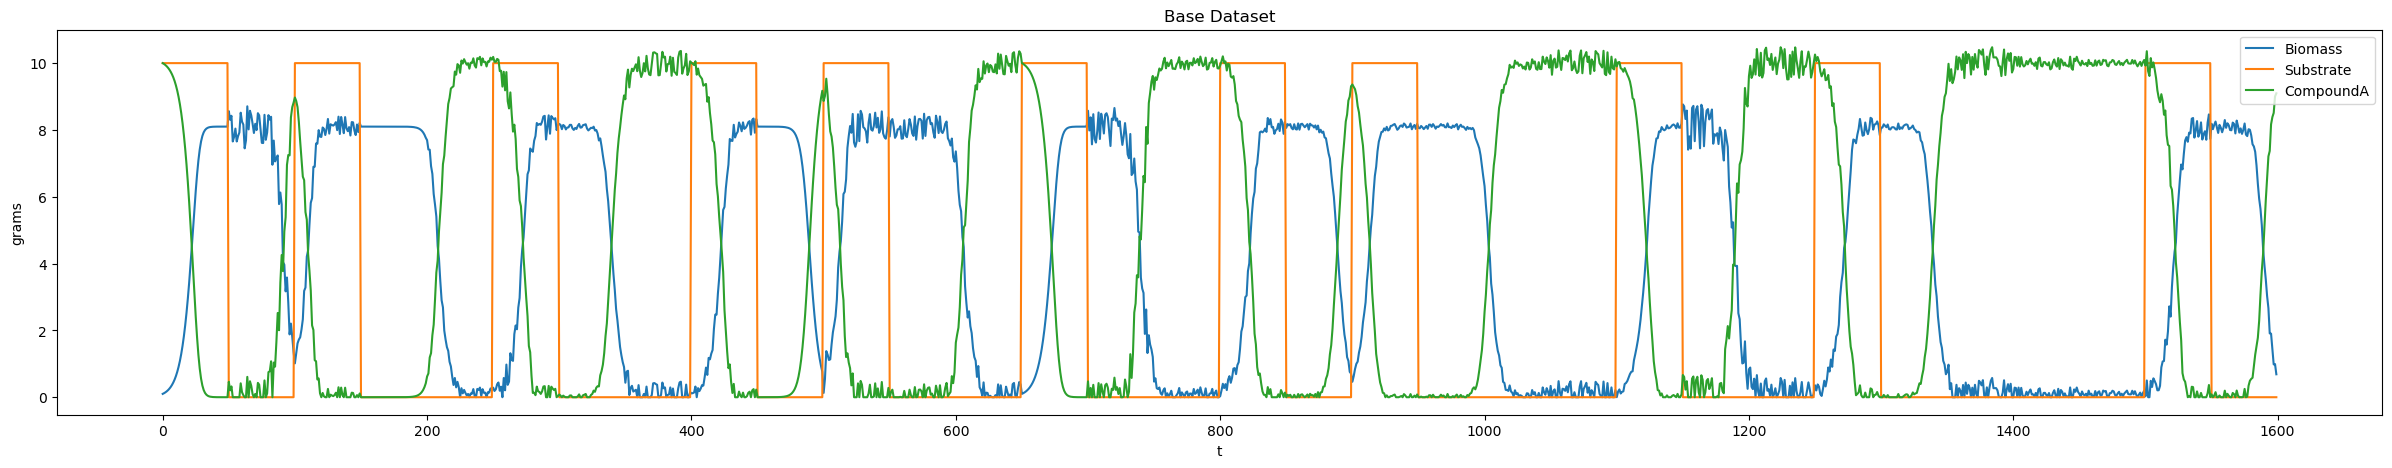

In [9]:
# Chart Data
x = np.arange(0,len(biomass))
plt.figure(figsize=(30,5))

plt.plot(x, biomass_clean, label='Biomass')
plt.plot(x, compoundA_clean, label='Substrate')
plt.plot(x, substrate_clean, label='CompoundA')

plt.xlabel('t')
plt.ylabel('grams')

plt.title('Base Dataset')
plt.legend()
plt.show()

In [10]:
# Data summarise after cleaning
all_data = np.column_stack((biomass_clean,compoundA_clean,substrate_clean))
pd.DataFrame(all_data, columns=["biomass","compoundA","substrate"]).describe()

,biomass,compoundA,substrate
count,1600.000000,1600.000000,1600.000000
mean,4.330050,3.437500,4.756387
std,3.593085,4.751074,4.477786
min,0.000000,0.000000,0.000000
25%,0.287887,0.000000,0.068709
50%,4.933330,0.000000,3.985052
75%,8.040682,10.000000,9.807322
max,8.764514,10.000000,10.476012


## Data splitting methodology

#### Current method
* Arbitrarily select first 80% of data, assuming that distribution and shape of last 20% is the same
* Time series data has temporaral order, i.e. the order is part of the relationship we want to model
* Random splitting could lead to loss of information and unreliable evaluation

#### Potential improvements 
* If different pattern observed (or eval is poor) then we will improve this section by changing the training/testing split methodology
* Another option is to explore cross validation - i.e. split the data into different subsets and mix it around different samples --may not be possible for sequential data

In [11]:
# Split Training data
def split_array(array, split = TRAINING_SPLIT): 
    train_size = int(len(array) * split)
    train_array = array[:train_size]
    test_array = array[train_size:]
    return train_array, test_array

biomass_train, biomass_test = split_array(biomass_clean, TRAINING_SPLIT)
compoundA_train, compoundA_test = split_array(compoundA_clean, TRAINING_SPLIT)
substrate_train, substrate_test = split_array(substrate_clean, TRAINING_SPLIT)

In [12]:
#Training data summary
all_data = np.column_stack((biomass_train,compoundA_train,substrate_train))
pd.DataFrame(all_data, columns=["biomass","compoundA","substrate"]).describe()

,biomass,compoundA,substrate
count,1280.000000,1280.000000,1280.000000
mean,4.576752,3.750000,4.451568
std,3.541278,4.843121,4.404088
min,0.000000,0.000000,0.000000
25%,0.421108,0.000000,0.058360
50%,5.954663,0.000000,2.726504
75%,8.069532,10.000000,9.651141
max,8.764514,10.000000,10.475310


In [13]:
# Combine compoundA and substrate as the two inputs into our Neural Network
def combine_inputs(a, b):
    c = []
    for i in range(len(a)):
        c.append([a[i], b[i]])
    return np.array(c)

inputs_train = combine_inputs(compoundA_train, substrate_train)
inputs_test = combine_inputs(compoundA_test, substrate_test)

# 3. Design of the Neural Network
* Design the multi-layer neural network. Given the number of training samples, propose a neural architecture taking into account
    * Ni - number of inputs
    * Nh - number of units in the hidden layer
    * No - number of outputs
* Decide the number of layers and their respective activation functions
* Remember, it's recommended your network accomplish the maximal number of parameters < (number of samples) / 10 
    * The number of weights dependent on the training size, currently assuming 80/20 training/test split. If this changes, then we should change the number of parameters accordingly
* Create the neural network using Keras and TensorFlow

In [14]:
# proposed architecture:
# Ni = 2
# Nh = 10,8
# No = 1

# Input layer (forward): (2+1) * 10 = 30
# Hidden layer 1 (forward): (10+1) * 8 = 88
# Hidden layer 2 (forwarD): (8+1) * 1 = 9
# Total number of parameters: 127 < 1280/10


In [15]:
def create_model(): #This is the baseline layer...
    nnet = Sequential() 
    
    # 2 Units in the input layer for Compound A and substrate
    nnet.add(Dense(10, input_dim=2, activation='linear')) # 2 input dimensions

    # Hidden Layer - #best practices here is 
    nnet.add(Dense(8, activation='sigmoid'))

    # One output layer
    nnet.add(Dense(1, activation='linear')) # Commonly used in regression problems - preferred because output should be continuous whereas reLu introduces non-linearity resulting in poor output
    print(nnet.summary())
    return nnet

# Notes:
# Sigmoid function was used in the input/hidden layers because resulting predictions appear to be more stable (extremes less pronounced)


# 4. Training
* Decide the training parameters Decide the training parameters such as loss function, optimizer, batch size, learning rate, and episodes
* Train the neural model and verify the loss values during the process 
* Verify possible overfitting problems.

In [16]:
#Set Base Parameters
LOSS_FUNCTION = 'mean_squared_error' # Common loss function for regression problem - better because it summarises the difference between continuous variable better than other functions
LEARNING_RATE = 0.0035 # Learning rate varies the update rate for the weights. Lower learning rate = Slower convergence, vice versa
#OPTIMIZER = SGD(learning_rate=LEARNING_RATE) # Difficulty excaping local minina + oscillation too unstable
OPTIMIZER = Adam(learning_rate=LEARNING_RATE) # Much better at escaping minina and more stable based on research and experimentation
BATCH_SIZE = 10
EPOCHS = 300

In [17]:
# Create the model
model = create_model()
model.summary()

model.compile(
        optimizer=OPTIMIZER, 
        loss=LOSS_FUNCTION,
        metrics=['accuracy']
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 8)                 88        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (Non

2023-08-02 15:34:21.142733: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 5. Training

* Assess your results plotting the network response for the test inputs against the test targets.
* Compute error indexes to complement the visual analysis. Use IA, RMS, and RSD.

In [18]:
def chart_output_vs_target(predicted, observed, chart_title='Observed vs Predicted Biomass'):
    x = np.arange(0,len(predicted))
    plt.figure(figsize=(30,5))

    plt.plot(x, predicted, label='Estimated Biomass') 
    plt.plot(x, observed, label='Real Biomass')
    
    plt.title(chart_title)
    plt.legend()
    plt.show()

def chart_loss_accuracy(predicted, observed, chart_title='Observed vs Predicted Loss / Accuracy'):
    loss = []
    for i in range(predicted.size):
        squared_error = (observed[i] - predicted[i]) ** 2
        loss.append(squared_error)

    x = np.arange(0,len(predicted))
    plt.figure(figsize=(30,5))

    plt.plot(x, observed, label='Actual Biomass')
    plt.plot(x, predicted, label='Estimated Biomass') 
    plt.plot(x, loss, label='loss (squared error)', color='Red')
    
    plt.title(chart_title)
    plt.legend()

def calc_ia(observed, predicted):
    n = len(observed)
    num = 0
    den = 0
    om = np.mean(observed)
    for i in range(0, n):
        num += (observed[i] - predicted[i]) ** 2
        den += (abs(observed[i]-om) + abs(predicted[i]-om)) ** 2

    ia = 1 - (num/den)
    return float(ia)

def calc_rms(observed, predicted):
    n = len(observed)
    num = 0
    den = 0
    for i in range(0, n):
        num += (observed[i] - predicted[i]) ** 2
        den += observed[i]**2
    
    rms = math.sqrt(num/den)
    return float(rms)

def calc_rsd(observed, predicted):
    n = len(observed)
    num = 0
    den = n
    for i in range(0, n):
        num += (observed[i] - predicted[i]) ** 2

    rsd = math.sqrt(num/den)
    return float(rsd)

def calculate_performance(predicted, observed, test_name):
    performance = {
        "test_name": test_name,
        "performance_metrics":{
        "IA": calc_ia(observed, predicted),
        "RMS": calc_rms(observed, predicted),
        "RSD": calc_rsd(observed, predicted)
        }
    }
    print(f'-- Model Performance --')
    print(f'IA = {performance["performance_metrics"]["IA"]}')
    print(f'RMS = {performance["performance_metrics"]["RMS"]}')
    print(f'RSD = {performance["performance_metrics"]["RSD"]}')
    return performance

model_performance = []

## PRE-TRAINING

 1/40 [..............................] - ETA: 3s

40/40 [==============================] - 0s 1ms/step
-- Model Performance --
IA = 0.48583465814590454
RMS = 0.9967546850801902
RSD = 5.7671984668049685


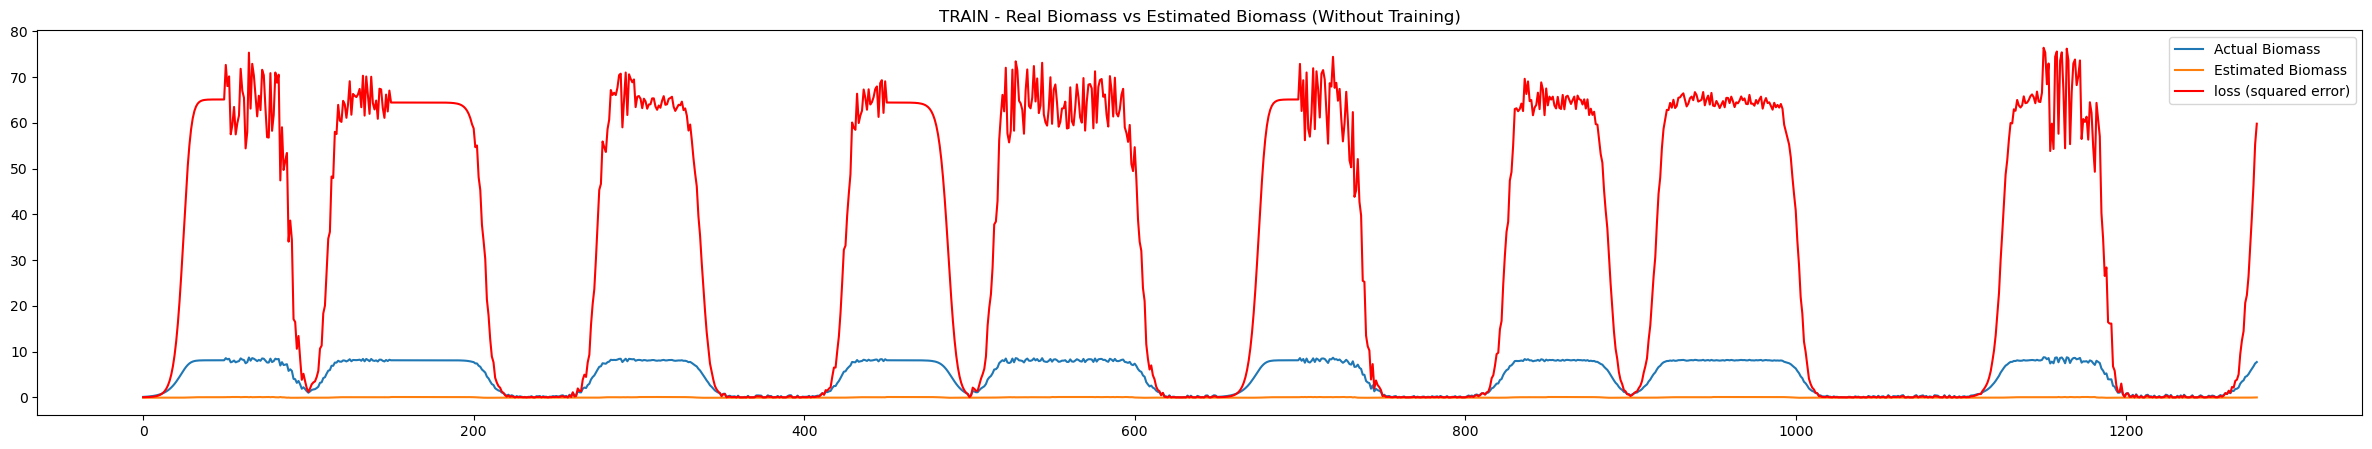

In [19]:
# Charting Training Set Without Training
observed = biomass_train
predicted = model.predict(inputs_train)
performance = calculate_performance(predicted, observed, 'Training set Pre-Training')
model_performance.append(performance)
# chart_output_vs_target(predicted, observed, 'TRAIN - Real Biomass vs Estimated Biomass (Without Training)')
chart_loss_accuracy(predicted, observed, 'TRAIN - Real Biomass vs Estimated Biomass (Without Training)')

10/10 [==============================] - 0s 803us/step
-- Model Performance --
IA = 0.4943488836288452
RMS = 0.9962838085090616
RSD = 4.915990211806085


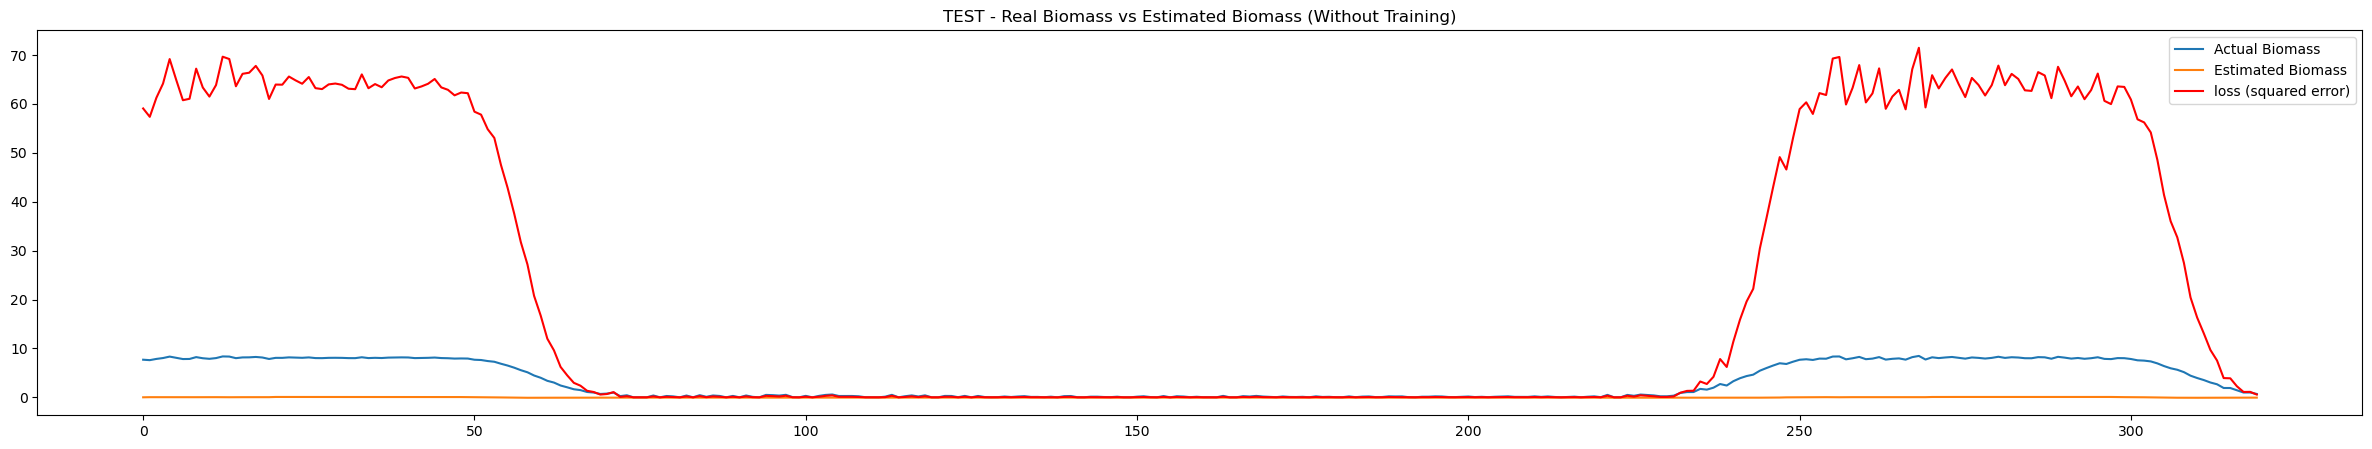

In [20]:
# Charting Test Set Without Training
observed = biomass_test
predicted = model.predict(inputs_test)
performance = calculate_performance(predicted, observed, 'Test set Pre-Training')
model_performance.append(performance)
# chart_output_vs_target(predicted, observed, 'TEST - Real Biomass vs Estimated Biomass (Without Training)')
chart_loss_accuracy(predicted, observed, 'TEST - Real Biomass vs Estimated Biomass (Without Training)')

## TRAINING

In [21]:
# Training the model
history = model.fit(inputs_train, biomass_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/300
128/128 [==============================] - 0s 859us/step - loss: 19.8741 - accuracy: 0.0086
Epoch 2/300
128/128 [==============================] - 0s 826us/step - loss: 5.8580 - accuracy: 0.0000e+00
Epoch 3/300
128/128 [==============================] - 0s 812us/step - loss: 2.1104 - accuracy: 0.0000e+00
Epoch 4/300
128/128 [==============================] - 0s 830us/step - loss: 1.3110 - accuracy: 0.0000e+00
Epoch 5/300
128/128 [==============================] - 0s 812us/step - loss: 0.5406 - accuracy: 0.0000e+00
Epoch 6/300
128/128 [==============================] - 0s 859us/step - loss: 0.3800 - accuracy: 0.0000e+00
Epoch 7/300
128/128 [==============================] - 0s 810us/step - loss: 0.3140 - accuracy: 0.0000e+00
Epoch 8/300
128/128 [==============================] - 0s 786us/step - loss: 0.2567 - accuracy: 0.0000e+00
Epoch 9/300
128/128 [==============================] - 0s 780us/step - loss: 0.2229 - accuracy: 0.0000e+00
Epoch 10/300
128/128 [==================

In [22]:
# Metric	Definition	                    Interpretation
# IA	    Index of Agreement	            Measures the correlation between the predicted values and the actual values
# RMS	    Root Mean Square	            Measures the average error between the predicted values and the actual values
# RSD	    Relative Standard Deviation	    Measures the variability of the predicted values

## POST-TRAINING

40/40 [==============================] - 0s 661us/step


-- Model Performance --
IA = 0.998413622379303
RMS = 0.048731075638563943
RSD = 0.28195681765350816


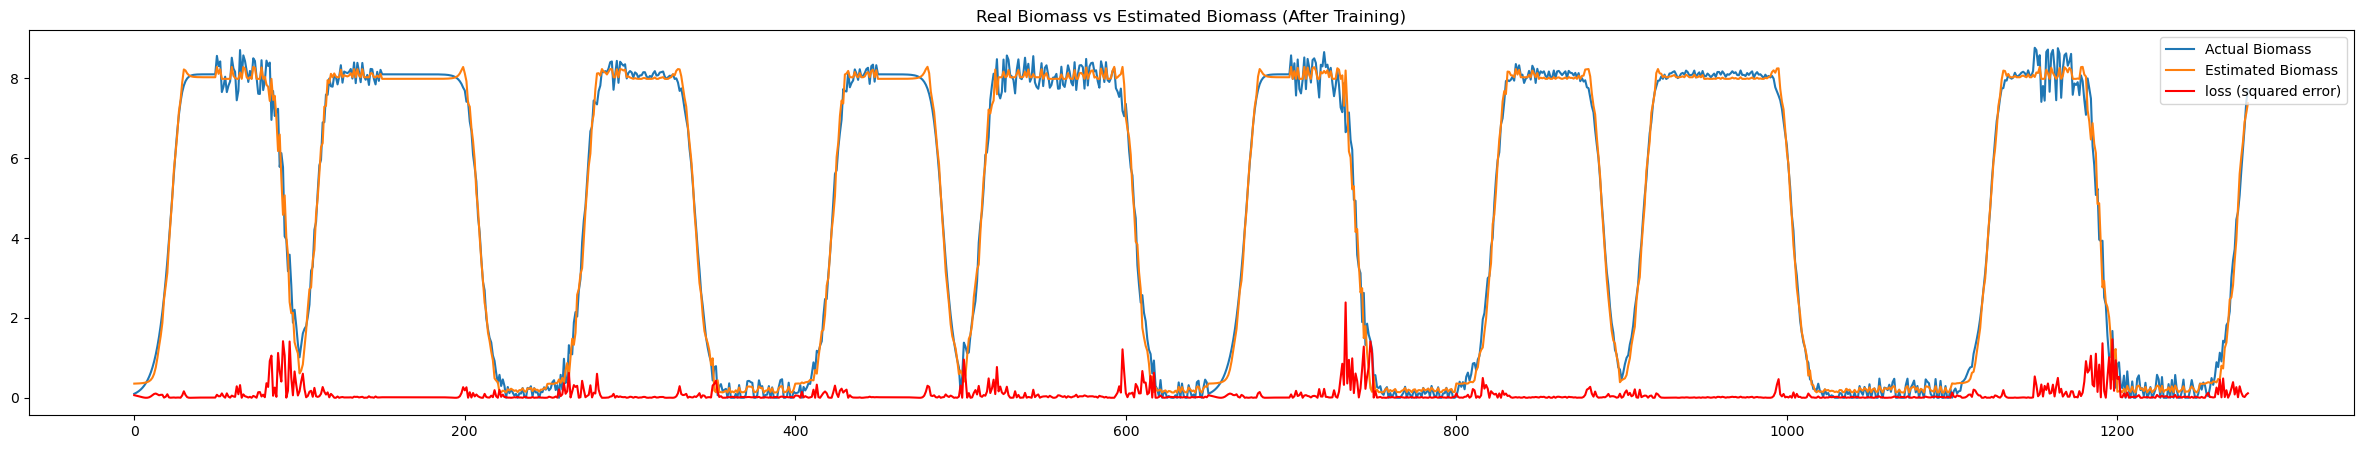

In [23]:
# Checking how we perform on the training set --> check potential overfitting
observed = biomass_train
predicted = model.predict(inputs_train)
performance = calculate_performance(predicted, observed, 'Training set After Training')
model_performance.append(performance)
# chart_output_vs_target(predicted, observed, 'Real Biomass vs Estimated Biomass (After Training)')
chart_loss_accuracy(predicted, observed, 'Real Biomass vs Estimated Biomass (After Training)')

10/10 [==============================] - 0s 706us/step
-- Model Performance --
IA = 0.9991970062255859
RMS = 0.0416733690113995
RSD = 0.20563003207777344


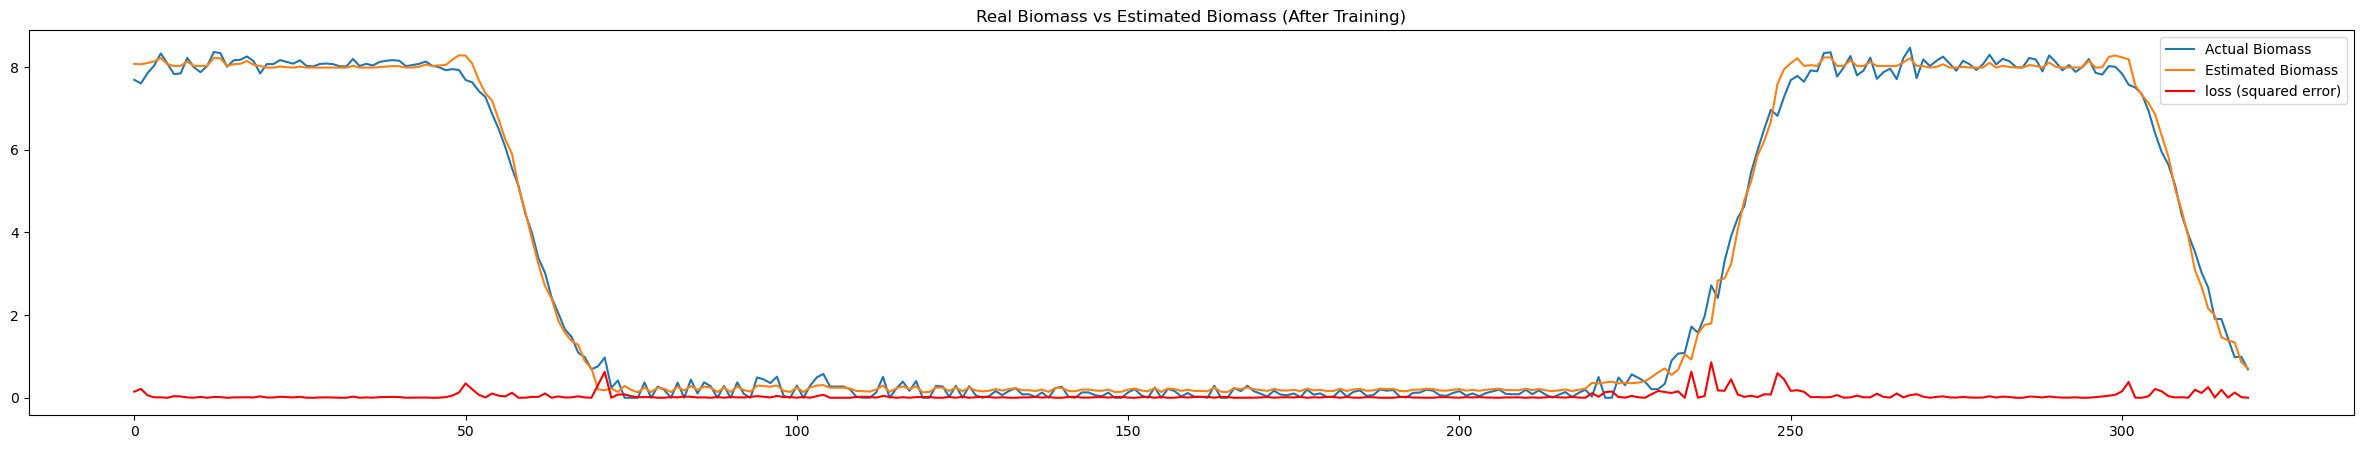

In [24]:
# Charting Test Set After Training
observed = biomass_test
predicted = model.predict(inputs_test)
performance = calculate_performance(predicted, observed, 'Test set After Training')
model_performance.append(performance)
# chart_output_vs_target(predicted, observed, 'Real Biomass vs Estimated Biomass (After Training)')
chart_loss_accuracy(predicted, observed, 'Real Biomass vs Estimated Biomass (After Training)')

## Modelling relationship between Loss and Accuracy

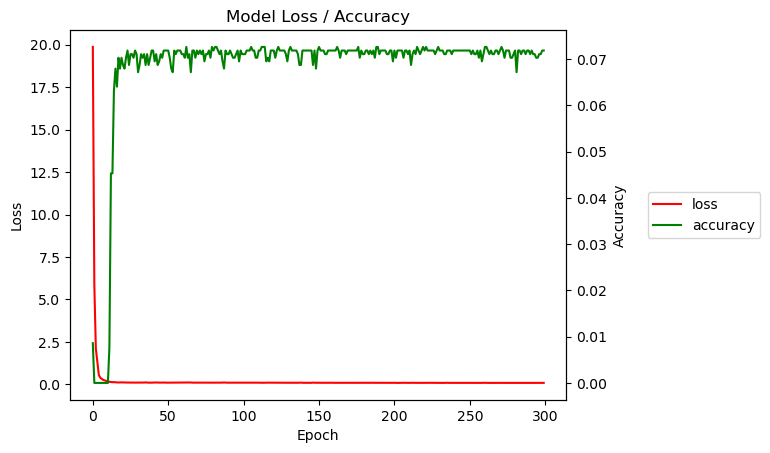

In [25]:
# Charts overlaid to show the relationship between Loss and Accuracy over time
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel("Epoch")
ax1.set_title("Model Loss / Accuracy")

lns1 = ax1.plot(history.history['loss'], label='loss', color='Red')
ax1.set_ylabel("Loss")

lns2 = ax2.plot(history.history['accuracy'], label='Accuracy', color='Green')
ax2.set_ylabel("Accuracy")

lns = lns1 + lns2
ax1.legend(lns, ['loss', 'accuracy'], loc='center left', bbox_to_anchor=(1.15, 0.5))

plt.show()

# 6. Computing and charting the error Indexes

Text(0.65, 0.29195681765350817, '0.28195681765350816')

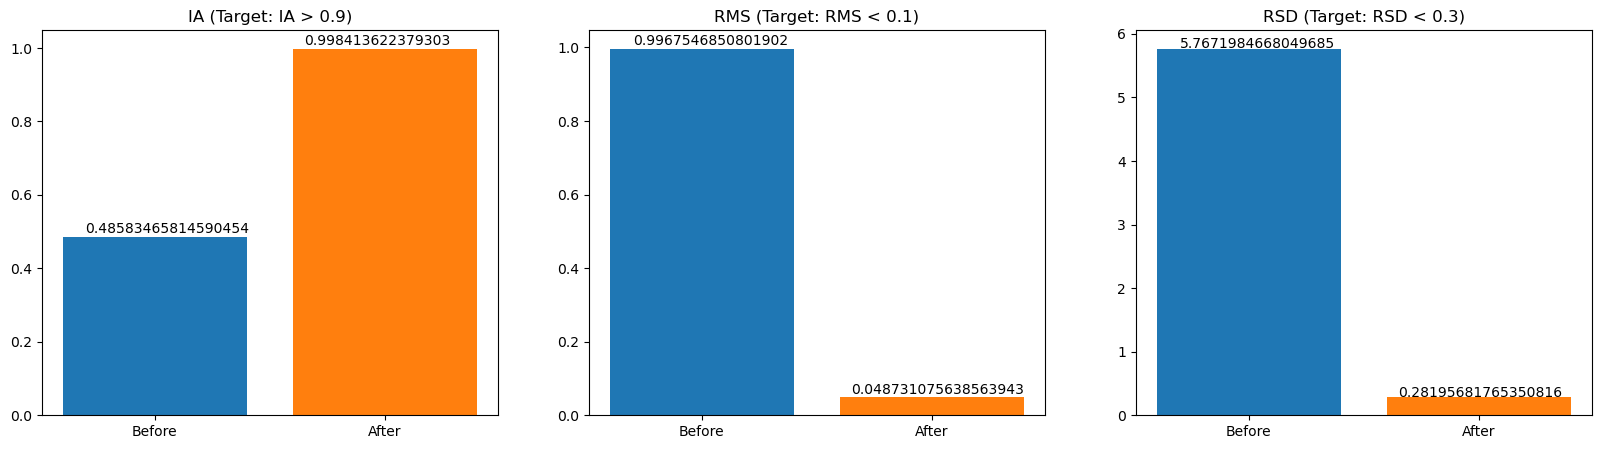

In [26]:
# Training Set Performance
pre_training = model_performance[0]['performance_metrics']
post_training = model_performance[2]['performance_metrics']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
axes[0].bar('Before', pre_training['IA'])
axes[0].bar('After', post_training['IA'])
axes[0].set_title('IA (Target: IA > 0.9)')
axes[0].annotate(str(pre_training['IA']), (-0.3, pre_training['IA'] + 0.01), color='black')
axes[0].annotate(str(post_training['IA']), (0.65, post_training['IA'] + 0.01), color='black')

axes[1].bar('Before', pre_training['RMS'])
axes[1].bar('After', post_training['RMS'])
axes[1].set_title('RMS (Target: RMS < 0.1)')
axes[1].annotate(str(pre_training['RMS']), (-0.3, pre_training['RMS'] + 0.01), color='black')
axes[1].annotate(str(post_training['RMS']), (0.65, post_training['RMS'] + 0.01), color='black')

axes[2].bar('Before', pre_training['RSD'])
axes[2].bar('After', post_training['RSD'])
axes[2].set_title('RSD (Target: RSD < 0.3)')
axes[2].annotate(str(pre_training['RSD']), (-0.3, pre_training['RSD'] + 0.01), color='black')
axes[2].annotate(str(post_training['RSD']), (0.65, post_training['RSD'] + 0.01), color='black')

Text(0.65, 0.21563003207777345, '0.20563003207777344')

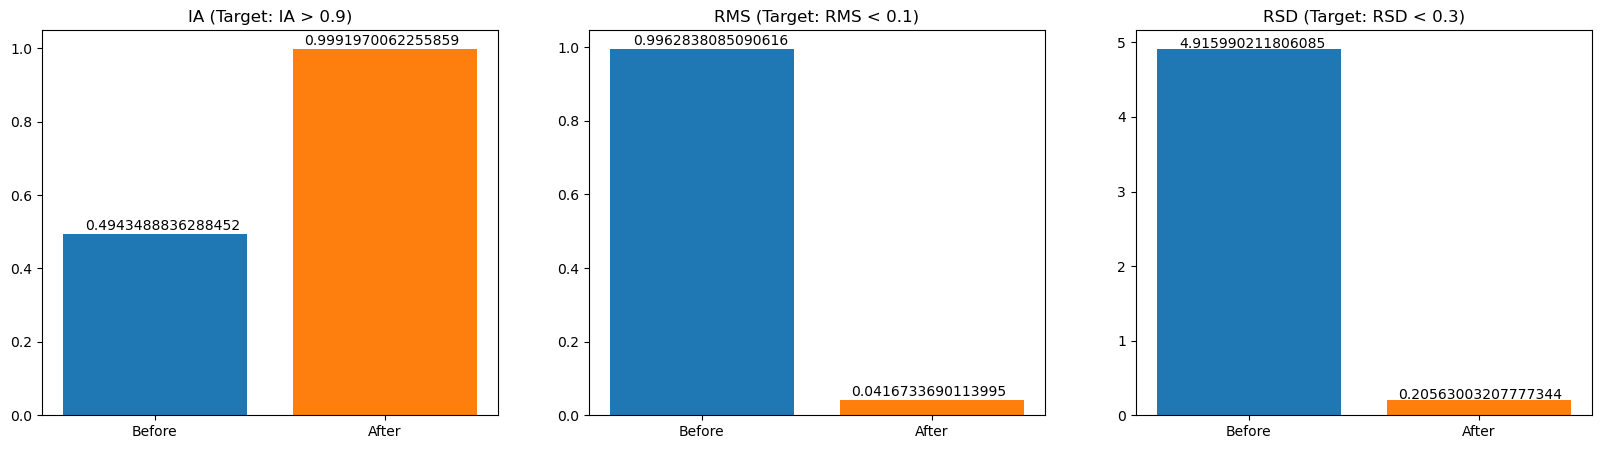

In [27]:
# Test Set Performance
pre_training = model_performance[1]['performance_metrics']
post_training = model_performance[3]['performance_metrics']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
axes[0].bar('Before', pre_training['IA'])
axes[0].bar('After', post_training['IA'])
axes[0].set_title('IA (Target: IA > 0.9)')
axes[0].annotate(str(pre_training['IA']), (-0.3, pre_training['IA'] + 0.01), color='black')
axes[0].annotate(str(post_training['IA']), (0.65, post_training['IA'] + 0.01), color='black')

axes[1].bar('Before', pre_training['RMS'])
axes[1].bar('After', post_training['RMS'])
axes[1].set_title('RMS (Target: RMS < 0.1)')
axes[1].annotate(str(pre_training['RMS']), (-0.3, pre_training['RMS'] + 0.01), color='black')
axes[1].annotate(str(post_training['RMS']), (0.65, post_training['RMS'] + 0.01), color='black')

axes[2].bar('Before', pre_training['RSD'])
axes[2].bar('After', post_training['RSD'])
axes[2].set_title('RSD (Target: RSD < 0.3)')
axes[2].annotate(str(pre_training['RSD']), (-0.3, pre_training['RSD'] + 0.01), color='black')
axes[2].annotate(str(post_training['RSD']), (0.65, post_training['RSD'] + 0.01), color='black')

------
## Hyperparameter Testing

In [28]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [29]:
#Run model
def testing_kit(mode = 'learning_rate', learning_rate_ = 0.0085, loss_function_ = 'mean_squared_error', epochs_ = 100, batch_size_ = 32, optimizer_ = 'adam'):
    map_dict = {'learning_rate':learning_rate_, 'loss_function':loss_function_, 'epochs':epochs_,'batch_size':batch_size_, 'optimizer':optimizer_}

    print(f"Testing for mode: <{mode}>\nWith value: <{map_dict[mode]}>\n")

    optimizer_ = Adam(learning_rate = learning_rate_) 
    if optimizer_ == 'SGD':
        optimizer_ = SGD(learning_rate = learning_rate_)
    else: 
        optimizer_ = Adam(learning_rate = learning_rate_)

    # Make model
    model = create_model()
    # Create the model
    model.compile(
            optimizer = optimizer_, 
            loss = loss_function_,
            metrics = ['accuracy']
        )

    history = model.fit(inputs_train, biomass_train, epochs = epochs_ , batch_size = batch_size_)

    #Validate Model - Training
    observed = biomass_train
    predicted = model.predict(inputs_train)
    performance = calculate_performance(predicted, observed, f'Training set for mode: <{mode}> with param: <{map_dict[mode]}>')
    model_performance.append(performance)
    
    #Validate Model - Test
    observed = biomass_test
    predicted = model.predict(inputs_test)
    performance = calculate_performance(predicted, observed, f'Testing set for mode: <{mode}> with param: <{map_dict[mode]}>')
    model_performance.append(performance)  

In [30]:
#Learning Rate Testing
hyper_param = [0.01,0.0085, 0.0075,0.005,0.001]
model_performance = []
for i in hyper_param:
    testing_kit(mode = 'learning_rate', learning_rate_ = i)

Testing for mode: <learning_rate>
With value: <0.01>

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                30        
                                                                 
 dense_4 (Dense)             (None, 8)                 88        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100


40/40 [==============================] - 0s 881us/step - loss: 26.1412 - accuracy: 0.0156
Epoch 2/100
40/40 [==============================] - 0s 804us/step - loss: 14.3990 - accuracy: 0.0000e+00
Epoch 3/100
40/40 [==============================] - 0s 828us/step - loss: 10.5055 - accuracy: 0.0000e+00
Epoch 4/100
40/40 [==============================] - 0s 820us/step - loss: 7.7665 - accuracy: 0.0000e+00
Epoch 5/100
40/40 [==============================] - 0s 766us/step - loss: 5.7454 - accuracy: 0.0000e+00
Epoch 6/100
40/40 [==============================] - 0s 790us/step - loss: 3.8087 - accuracy: 0.0000e+00
Epoch 7/100
40/40 [==============================] - 0s 778us/step - loss: 2.2061 - accuracy: 0.0000e+00
Epoch 8/100
40/40 [==============================] - 0s 793us/step - loss: 1.3062 - accuracy: 0.0000e+00
Epoch 9/100
40/40 [==============================] - 0s 789us/step - loss: 0.7988 - accuracy: 0.0000e+00
Epoch 10/100
40/40 [==============================] - 0s 777us/step 

In [31]:
for i in model_performance:
    print(i)
# Choose 0.0085

{'test_name': 'Training set for mode: <learning_rate> with param: <0.01>', 'performance_metrics': {'IA': 0.9975804090499878, 'RMS': 0.059756724078135474, 'RSD': 0.3457509454961111}}
{'test_name': 'Testing set for mode: <learning_rate> with param: <0.01>', 'performance_metrics': {'IA': 0.9982894659042358, 'RMS': 0.060607885185920356, 'RSD': 0.2990591365501502}}
{'test_name': 'Training set for mode: <learning_rate> with param: <0.0085>', 'performance_metrics': {'IA': 0.998097836971283, 'RMS': 0.05327993556677822, 'RSD': 0.308276411657556}}
{'test_name': 'Testing set for mode: <learning_rate> with param: <0.0085>', 'performance_metrics': {'IA': 0.9988771080970764, 'RMS': 0.04935181640075377, 'RSD': 0.24351800490909248}}
{'test_name': 'Training set for mode: <learning_rate> with param: <0.0075>', 'performance_metrics': {'IA': 0.9981286525726318, 'RMS': 0.052757143474230654, 'RSD': 0.30525154088933437}}
{'test_name': 'Testing set for mode: <learning_rate> with param: <0.0075>', 'performance

---

In [32]:
#Batch size Testing
hyper_param = [16,32,64,128]
model_performance = []
for i in hyper_param:
    testing_kit(mode = 'batch_size', learning_rate_ = 0.0085, batch_size_ = i)

Testing for mode: <batch_size>
With value: <16>

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 10)                30        
                                                                 
 dense_19 (Dense)            (None, 8)                 88        
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
80/80 [==============================] - 0s 827us/step - loss: 15.1725 - accuracy: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 0s 811us/step - loss: 3.9597 - accuracy: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 0s 847us/step - loss: 1.2703 - accuracy: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 0s 825us/step - loss: 0.4853 - accuracy: 0.0000e+00
Epoch 5/100
80/80 [==============================] - 0s 779us/step - loss: 0.2705 - accuracy: 0.0000e+00
Epoch 6/100
80/80 [==============================] - 0s 789us/step - loss: 0.1878 - accuracy: 0.0242
Epoch 7/100
80/80 [==============================] - 0s 807us/step - loss: 0.1386 - accuracy: 0.0609
Epoch 8/100
80/80 [==============================] - 0s 791us/step - loss: 0.1388 - accuracy: 0.0672
Epoch 9/100
80/80 [==============================] - 0s 802us/step - loss: 0.1211 - accuracy: 0.0680
Epoch 10/100
80/80 [==============================] - 0s 829us/step - 

In [33]:
for i in model_performance:
    print(i)
# Choose 32 batch size

{'test_name': 'Training set for mode: <batch_size> with param: <16>', 'performance_metrics': {'IA': 0.9980047345161438, 'RMS': 0.05406258948958162, 'RSD': 0.3128048244567387}}
{'test_name': 'Testing set for mode: <batch_size> with param: <16>', 'performance_metrics': {'IA': 0.9987847805023193, 'RMS': 0.050924578008374556, 'RSD': 0.25127852861505573}}
{'test_name': 'Training set for mode: <batch_size> with param: <32>', 'performance_metrics': {'IA': 0.9980096817016602, 'RMS': 0.054094128924303736, 'RSD': 0.31298731715965866}}
{'test_name': 'Testing set for mode: <batch_size> with param: <32>', 'performance_metrics': {'IA': 0.9989731907844543, 'RMS': 0.04682467411498, 'RSD': 0.23104825950058633}}
{'test_name': 'Training set for mode: <batch_size> with param: <64>', 'performance_metrics': {'IA': 0.9974339604377747, 'RMS': 0.061838845840059324, 'RSD': 0.3577980604964646}}
{'test_name': 'Testing set for mode: <batch_size> with param: <64>', 'performance_metrics': {'IA': 0.9986669421195984, 

---

In [34]:
# Optimizer testing
hyper_param = ['adam','SGD']
model_performance = []
for i in hyper_param:
    testing_kit(mode = 'optimizer', learning_rate_ = 0.0085, batch_size_ = 32, optimizer_=i)

Testing for mode: <optimizer>
With value: <adam>

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 10)                30        
                                                                 
 dense_31 (Dense)            (None, 8)                 88        
                                                                 
 dense_32 (Dense)            (None, 1)                 9         
                                                                 
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
40/40 [==============================] - 0s 910us/step - loss: 19.2342 - accuracy: 0.0000e+00
Epoch 2/100
40/40 [==============================] - 0s 817us/step - loss: 7.6108 - accuracy: 0.0000e+00
Epoch 3/100
40/40 [==============================] - 0s 801us/step - loss: 3.3636 - accuracy: 0.0000e+00
Epoch 4/100
40/40 [==============================] - 0s 796us/step - loss: 1.9960 - accuracy: 0.0000e+00
Epoch 5/100
40/40 [==============================] - 0s 813us/step - loss: 1.2839 - accuracy: 0.0000e+00
Epoch 6/100
40/40 [==============================] - 0s 789us/step - loss: 0.8377 - accuracy: 0.0000e+00
Epoch 7/100
40/40 [==============================] - 0s 849us/step - loss: 0.5569 - accuracy: 0.0000e+00
Epoch 8/100
40/40 [==============================] - 0s 814us/step - loss: 0.3843 - accuracy: 0.0000e+00
Epoch 9/100
40/40 [==============================] - 0s 864us/step - loss: 0.2899 - accuracy: 0.0000e+00
Epoch 10/100
40/40 [==============================] - 

In [35]:
for i in model_performance:
    print(i)
# Choose Adam

{'test_name': 'Training set for mode: <optimizer> with param: <adam>', 'performance_metrics': {'IA': 0.9979938864707947, 'RMS': 0.05434882077085605, 'RSD': 0.3144609556940896}}
{'test_name': 'Testing set for mode: <optimizer> with param: <adam>', 'performance_metrics': {'IA': 0.9987025856971741, 'RMS': 0.052730259911372084, 'RSD': 0.26018835390891437}}
{'test_name': 'Training set for mode: <optimizer> with param: <SGD>', 'performance_metrics': {'IA': 0.9982335567474365, 'RMS': 0.05133316314696986, 'RSD': 0.29701242277867557}}
{'test_name': 'Testing set for mode: <optimizer> with param: <SGD>', 'performance_metrics': {'IA': 0.9990730285644531, 'RMS': 0.04482419080463278, 'RSD': 0.22117721646837776}}


---

In [36]:
# Loss Function Testing
hyper_param = ['mean_squared_error', 'mean_absolute_error', 'huber_loss']
model_performance = []
for i in hyper_param:
    testing_kit(mode = 'loss_function', learning_rate_ = 0.0085, batch_size_ = 32, loss_function_ = i)

Testing for mode: <loss_function>
With value: <mean_squared_error>

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 10)                30        
                                                                 
 dense_37 (Dense)            (None, 8)                 88        
                                                                 
 dense_38 (Dense)            (None, 1)                 9         
                                                                 
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
40/40 [==============================] - 0s 898us/step - loss: 31.9805 - accuracy: 0.0328
Epoch 2/100
40/40 [==============================] - 0s 787us/step - loss: 19.5748 - accuracy: 0.0000e+00
Epoch 3/100
40/40 [==============================] - 0s 815us/step - loss: 12.7043 - accuracy: 0.0000e+00
Epoch 4/100
40/40 [==============================] - 0s 816us/step - loss: 9.6864 - accuracy: 0.0000e+00
Epoch 5/100
40/40 [==============================] - 0s 782us/step - loss: 7.4929 - accuracy: 0.0000e+00
Epoch 6/100
40/40 [==============================] - 0s 896us/step - loss: 5.4022 - accuracy: 0.0000e+00
Epoch 7/100
40/40 [==============================] - 0s 870us/step - loss: 3.7552 - accuracy: 0.0000e+00
Epoch 8/100
40/40 [==============================] - 0s 828us/step - loss: 2.6234 - accuracy: 0.0000e+00
Epoch 9/100
40/40 [==============================] - 0s 868us/step - loss: 1.8491 - accuracy: 0.0000e+00
Epoch 10/100
40/40 [==============================] - 0s

In [37]:
for i in model_performance:
    print(i)
# Choose MSE

{'test_name': 'Training set for mode: <loss_function> with param: <mean_squared_error>', 'performance_metrics': {'IA': 0.9980337619781494, 'RMS': 0.05440080159685064, 'RSD': 0.3147617152755431}}
{'test_name': 'Testing set for mode: <loss_function> with param: <mean_squared_error>', 'performance_metrics': {'IA': 0.9990425109863281, 'RMS': 0.04564770992720311, 'RSD': 0.22524073226271787}}
{'test_name': 'Training set for mode: <loss_function> with param: <mean_absolute_error>', 'performance_metrics': {'IA': 0.9982457160949707, 'RMS': 0.051270968553287145, 'RSD': 0.29665258508562453}}
{'test_name': 'Testing set for mode: <loss_function> with param: <mean_absolute_error>', 'performance_metrics': {'IA': 0.9991190433502197, 'RMS': 0.04374856882649554, 'RSD': 0.2158697511827851}}
{'test_name': 'Training set for mode: <loss_function> with param: <huber_loss>', 'performance_metrics': {'IA': 0.9979545474052429, 'RMS': 0.05482721151032317, 'RSD': 0.3172289079030552}}
{'test_name': 'Testing set for

---

In [38]:
# Epoch Testing
hyper_param = [100,150,200]
model_performance = []
for i in hyper_param:
    testing_kit(mode = 'epochs', learning_rate_ = 0.0085, batch_size_ = 32, loss_function_ = 'mean_squared_error', epochs_ = i)

Testing for mode: <epochs>
With value: <100>

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 10)                30        
                                                                 
 dense_46 (Dense)            (None, 8)                 88        
                                                                 
 dense_47 (Dense)            (None, 1)                 9         
                                                                 
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
40/40 [==============================] - 0s 839us/step - loss: 20.9281 - accuracy: 0.0047
Epoch 2/100
40/40 [==============================] - 0s 888us/step - loss: 10.8484 - accuracy: 0.0000e+00
Epoch 3/100
40/40 [==============================] - 0s 809us/step - loss: 4.5038 - accuracy: 0.0000e+00
Epoch 4/100
40/40 [==============================] - 0s 899us/step - loss: 1.7638 - accuracy: 0.0000e+00
Epoch 5/100
40/40 [==============================] - 0s 1ms/step - loss: 0.8354 - accuracy: 0.0000e+00
Epoch 6/100
40/40 [==============================] - 0s 1ms/step - loss: 0.4963 - accuracy: 0.0000e+00
Epoch 7/100
40/40 [==============================] - 0s 914us/step - loss: 0.3366 - accuracy: 0.0000e+00
Epoch 8/100
40/40 [==============================] - 0s 865us/step - loss: 0.2367 - accuracy: 0.0000e+00
Epoch 9/100
40/40 [==============================] - 0s 870us/step - loss: 0.1878 - accuracy: 0.0000e+00
Epoch 10/100
40/40 [==============================] - 0s 804u

In [39]:
for i in model_performance:
    print(i)
# Choose 100 but generally lower the better (risk of overfitting if too many epochs)

{'test_name': 'Training set for mode: <epochs> with param: <100>', 'performance_metrics': {'IA': 0.9978210926055908, 'RMS': 0.05761931302304185, 'RSD': 0.33338394625188067}}
{'test_name': 'Testing set for mode: <epochs> with param: <100>', 'performance_metrics': {'IA': 0.998725414276123, 'RMS': 0.05295421772685133, 'RSD': 0.26129343575233716}}
{'test_name': 'Training set for mode: <epochs> with param: <150>', 'performance_metrics': {'IA': 0.9977592825889587, 'RMS': 0.05783181302854933, 'RSD': 0.33461346412028725}}
{'test_name': 'Testing set for mode: <epochs> with param: <150>', 'performance_metrics': {'IA': 0.9988999366760254, 'RMS': 0.048726003667805176, 'RSD': 0.24043003891052298}}
{'test_name': 'Training set for mode: <epochs> with param: <200>', 'performance_metrics': {'IA': 0.9983171820640564, 'RMS': 0.05030106275665887, 'RSD': 0.29104072667358977}}
{'test_name': 'Testing set for mode: <epochs> with param: <200>', 'performance_metrics': {'IA': 0.9991003274917603, 'RMS': 0.0442703

------